<h1 style="color:red">KAKAOTALK</h1>

- 함수정의
- 카톡에 적용
- 영화대본에 적용 [Joker, Harry Potter, Love Actually]

#### 카카오톡 파일 처리 함수

In [1]:
import os
os.chdir("C:/Users/beomj/Onedrive/바탕 화면");

        
def conversation_to_list(kakaotalk_file_name, Month, Day, AM, Hour, Minute):
    
    length_of_list = 20
    name_list = []
    talk_list = []
    
    f = open(kakaotalk_file_name,'rt',encoding='UTF8');
    lines = f.readlines()
    #check Month, Day, Hour, Minute and choose 20 words
    temp_lines = []
    m=0
    d=0
    c=0
    for line in lines:
        if(line.find(str(Month)+"월 "+str(Day)+"일") !=-1 and line.find('[')==-1):
            m=1
        if(m==1 and AM and line.find("오전 "+str(Hour)+":"+Minute)!=-1):
            d=1
        if(m==1 and not AM and line.find("오후 "+str(Hour)+":"+Minute)!=-1):
            d=1
        if(m==1 and d==1):
            temp_lines.append(line)
            c += 1
        if(c== length_of_list):
            break
    lines = temp_lines
    
    # get lines 
    for line in lines:    
        if(line.find('[')==0):
            index1 = line.find('[') +1
            index2 = line.find(']')
            index3 = line.find(']',index2+1) +1

            name2 = line[index1:index2]
            name_list.append(name2)
            talk_list.append(line[index3+1:])

    f.close()

    return name_list, talk_list


## 파파고 번역 함수

In [2]:
import requests
# 파파고 스트링 번역

def papago_translate(context):
    try:
        USER_ID = "svrfjDI6SLeRFekWQEOz" # 개발자센터에서 발급받은 Client ID 값
        USER_SECRET = "JLKglR7QQM" # 개발자센터에서 발급받은 Client Secret 값
        url = "https://openapi.naver.com/v1/papago/n2mt"
        headers= {"X-Naver-Client-Id": USER_ID, "X-Naver-Client-Secret":USER_SECRET}
        params = {"source": "ko", "target": "en", "text": context}
        response = requests.post(url, headers=headers, data=params)
        res = response.json()
        return res['message']['result']['translatedText']
    except:
        return "PAPAGO_FAILED"

# talk_list 번역
def conv_translate(talk_list):
    translated_list = []
    for i in talk_list:
        new = papago_translate(i)
        translated_list.append(new)
    return translated_list


## 감정 계산 함수

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def make_sent_list(trans_list):
    sent_list = []
    senti_analyzer = SentimentIntensityAnalyzer()
    for i in trans_list:
        score=senti_analyzer.polarity_scores(i)['compound']
        sent_list.append(score)
    return sent_list
    
    
def chat_labeling(score):
    if score>=0.3:
        return 'Good'
    elif score<=-0.3:
        return 'Bad'
    else:
        return "SoSo"


# Moving Average

In [24]:
import  numpy as np

def moving_average(sent_list):
    
    averaged = []
    for index,sent in enumerate(sent_list):
        if(index>3):
            averaged.append(np.mean(sent_list[index-3]*0.25 
                                   + sent_list[index-2]*0.35
                                   + sent_list[index-1]*0.5
                                   + sent_list[index]))
        else:

            averaged.append(sent)
            
    return averaged

## Plot 함수

In [5]:
# Make df for plotting
import pandas as pd
def make_sent_df(name_list, sent_list, decreasing):
    #declare return df
    df = pd.DataFrame()
    
    unique_name = list(set(name_list))
    unique_name.sort()
    # append person
    for person in  unique_name:
        df[person] = sent_list

    # not talker dealing
    for i in df.index:
        for c in df.columns:
            if name_list[i] != c:
                df.loc[i,c] = 100
    df.loc[-1,]= 0
    df =df.sort_index()        
    for i in df.index:
        for c in df.columns:
            if df.loc[i,c] == 100:
                prev = df.loc[i-1,c]
                if prev <0.05 and prev>-0.05:
                     df.loc[i,c]=0
                elif prev>0:
                    df.loc[i,c] = df.loc[i-1,c]-decreasing
                else:
                    df.loc[i,c] = df.loc[i-1,c]+decreasing
    df.loc[len(df)-1,]= df.loc[len(df)-2,]
    df.loc[len(df)-2,]= df.loc[len(df)-3,]
    return df
        
# Plotting
from scipy.interpolate import interp1d
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def plot_time_sentiment(df, time):
    
    new_index = np.arange(-1, len(df)-2, 0.01)
    df2 = pd.DataFrame(index = new_index)
    
    s = ''.join(df.columns)

    
    for c in df.columns:
        f1 = interp1d(df.index, df[c], kind='cubic')
        df2[c] = f1(new_index)
     
    df2.index = new_index
    
    ax2 = df2.plot.line()
    ax2.set_title(time)
    ax2.set_xlabel("time")
    ax2.set_ylabel("Sentiment")
    ax2.plot(new_index, [0 for i in new_index],'r')

<h1 style="color:red">MAIN</h1>

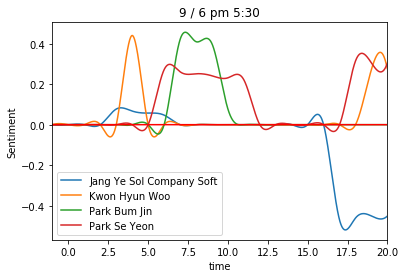

In [25]:
# import pandas as pd

# set time
Month = 9
Day = 6
AM = False
Hour = 5
Minute ="30"


#read file
name_list, talk_list=conversation_to_list("KakaoTalk_20191119_2021_54_768_group.txt",Month,Day,AM,Hour,Minute)

#translate
trans_list = conv_translate(talk_list[0:20])
name_list = conv_translate(name_list)

#make df
df_chat = pd.DataFrame([name_list,talk_list,trans_list], index=['name','ko','en']).T
df_chat['sent']=make_sent_list(df_chat['en'])
df_chat['labeling']=df_chat['sent'].apply(lambda x:chat_labeling(x))

#plot
if AM:
    time = str(Month) +" / " +str(Day) +" am " + str(Hour) +":"+str(Minute)
else:
    time = str(Month) +" / " +str(Day) +" pm " + str(Hour) +":"+str(Minute)
df_for_plot = make_sent_df(df_chat['name'], df_chat['sent'], 0.01)
plot_time_sentiment(df_for_plot, time)    


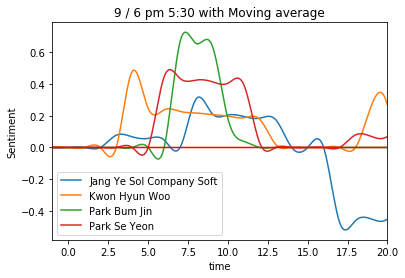

In [26]:
# Moving Average

df_chat['sent']=moving_average(df_chat['sent'])
df_chat['labeling']=df_chat['sent'].apply(lambda x:chat_labeling(x))

#plot
if AM:
    time = str(Month) +" / " +str(Day) +" am " + str(Hour) +":"+str(Minute)
else:
    time = str(Month) +" / " +str(Day) +" pm " + str(Hour) +":"+str(Minute)
time = time + ' with Moving average'
df_for_plot = make_sent_df(df_chat['name'], df_chat['sent'], 0.01)
plot_time_sentiment(df_for_plot, time)    


In [22]:
df_chat

,name,ko,en,sent,labeling
0,Kwon Hyun Woo,책 새거 25000에 중고로 파는데 이거 사서 제본하는거 어때요?\n,"I'm selling a new book for 25000, so why don't...",0.000000,SoSo
1,Jang Ye Sol Company Soft,저 책 구햇서요 !\n,I got that book!,0.000000,SoSo
2,Kwon Hyun Woo,아 그래요?? 그럼 각자 구매하는걸로 해요??\n,Oh really? Then should we buy each?,0.000000,SoSo
3,Jang Ye Sol Company Soft,아님 제걸로 제본 하실ㄹ래여...??\n,Or do you want my copy?,0.077200,SoSo
4,Kwon Hyun Woo,그것도 좋아요\n,"That's good, too.",0.077200,SoSo
5,Kwon Hyun Woo,다른 분들은 어떠세요??\n,How about the others?,0.479000,Good
6,Park Se Yeon,저도 둘다 괜찮아요!\n,I'm fine with both of you!,0.247220,SoSo
7,Park Bum Jin,저도 좋아요!\n,I like it too!,0.444840,Good
8,Jang Ye Sol Company Soft,지금 제본은 할 수 있는데 화요일까지 학교에 갈 일이 없어서... 편의점 택배로 오...,"I can do the binding right now, but I don't ha...",0.665700,Good
9,Jang Ye Sol Company Soft,뭐가 좋을가요?!\n,What do you like?!,0.304940,Good


# JOKER

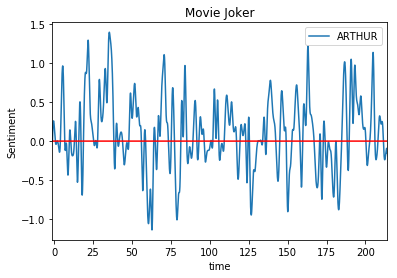

In [29]:
    Actor = 'JOKER'
    Actor = 'ARTHUR'

    name_list = []
    talk_list = []
    
    
    joker = open('joker_new_final.txt','rt',encoding='UTF8');
    lines = joker.readlines()
    flag = 0
    # get lines 
    for index, line in enumerate(lines):    
            
        if(line.find(Actor)!=-1):
            name_list.append(Actor)
            talk_list.append(lines[index+1] +lines[index+2]+lines[index])
            

    joker.close()

    #make df
df_joker = pd.DataFrame([name_list,talk_list], index=['name','en']).T
df_joker['sent']=make_sent_list(df_joker['en'])
df_joker['sent']=moving_average(df_joker['sent'])
#plot

df_for_plot = make_sent_df(df_joker['name'], df_joker['sent'], 0.01)
plot_time_sentiment(df_for_plot, "Movie Joker")    

# Harry Potter

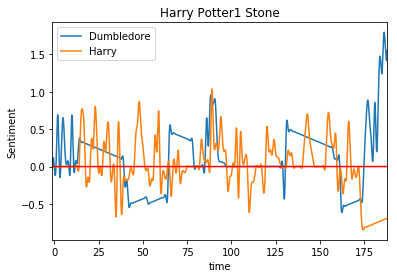

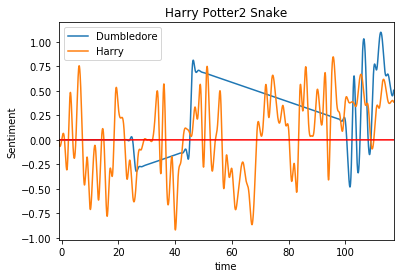

In [31]:
    name_list = []
    talk_list = []
    
    harry = open('HarryPotter1.txt','rt');
    lines = harry.readlines()
    flag = 0
    # get lines 
    for line in lines:    
            
        if(line.find('Harry:')!=-1):
            name_list.append("Harry")
            talk_list.append(line[5:])
        if(line.find('Dumbledore')!= -1):
            name_list.append("Dumbledore")
            talk_list.append(line[len('Dumbledore')+1:])

    harry.close()

    #make df
df_harry = pd.DataFrame([name_list,talk_list], index=['name','en']).T
df_harry['sent']=make_sent_list(df_harry['en'])
df_harry['sent']=moving_average(df_harry['sent'])
#plot

df_for_plot = make_sent_df(df_harry['name'], df_harry['sent'], 0.01)
plot_time_sentiment(df_for_plot, "Harry Potter1 Stone")    


#2 

    name_list = []
    talk_list = []
    
    harry = open('Harry Potter2.txt','rt', encoding = 'UTF-8');
    lines = harry.readlines()
    flag = 0
    # get lines 
    for line in lines:    
            
        if(line.find('Harry:')!=-1):
            name_list.append("Harry")
            talk_list.append(line[5:])
        if(line.find('Professor Dumbledore:')!= -1):
            name_list.append("Dumbledore")
            talk_list.append(line[len('Professor Dumbledore:')+1:])

    harry.close()

    #make df
df_harry = pd.DataFrame([name_list,talk_list], index=['name','en']).T
df_harry['sent']=make_sent_list(df_harry['en'])
df_harry['sent']=moving_average(df_harry['sent'])
#plot

df_for_plot = make_sent_df(df_harry['name'], df_harry['sent'], 0.01)
plot_time_sentiment(df_for_plot, "Harry Potter2 Snake")    


# Love Actually

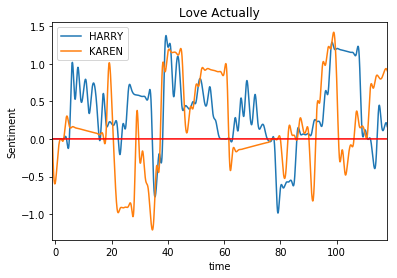

In [32]:
    name_list = []
    talk_list = []
    
    love = open('love actually.txt','rt', encoding = 'UTF-8');
    lines = love.readlines()
    flag = 0
    # get lines 
    for line in lines:    
            
        if(line.find('HARRY:')!=-1):
            name_list.append("HARRY")
            talk_list.append(line[len('KAREN')+1:])
        if(line.find('KAREN')!= -1):
            name_list.append("KAREN")
            talk_list.append(line[len('KAREN')+1:])

    harry.close()

    #make df
df_love = pd.DataFrame([name_list,talk_list], index=['name','en']).T
df_love['sent']=make_sent_list(df_love['en'])
df_love['sent']=moving_average(df_love['sent'])
#plot

df_for_plot = make_sent_df(df_love['name'], df_love['sent'], 0.01)
plot_time_sentiment(df_for_plot, "Love Actually")    

# Space Jam

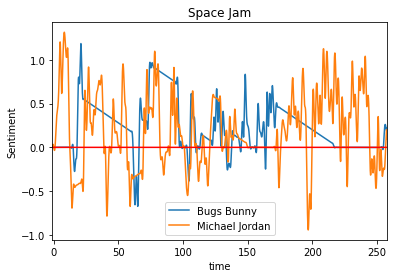

In [33]:
    name_list = []
    talk_list = []
    
    file = open('Space Jam.txt','rt', encoding = 'ANSI');
    lines = file.readlines()

    # get lines 
    for line in lines:    
            
        if(line.find('Michael Jordan:')!=-1):
            name_list.append("Michael Jordan")
            talk_list.append(line[len('Michael Jordan:')+1:])
        if(line.find('Bugs Bunny:')!= -1):
            name_list.append("Bugs Bunny")
            talk_list.append(line[len('Bugs Bunny:')+1:])

    file.close()

    #make df
df = pd.DataFrame([name_list,talk_list], index=['name','en']).T
df['sent']=make_sent_list(df['en'])
df['sent']=moving_average(df['sent'])
#plot

df_for_plot = make_sent_df(df['name'], df['sent'], 0.01)
plot_time_sentiment(df_for_plot, "Space Jam")    